In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams.update({'font.size': 12})

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import scipy.signal
import tifffile
import zarr

import context
from msi_zarr_analysis.utils.autocrop import autocrop
from msi_zarr_analysis.utils.iter_chunks import iter_loaded_chunks

sys.path[:2]=['/home/maxime/cytomine-repos/Cytomine-python-client', '/home/maxime/repos/msi_zarr_analysis']


In [3]:
r13 = zarr.open_group("/home/maxime/Desktop/datasets/comulis13_bin-auto-32768.zarr/", mode='r')

In [4]:
def get_avg_int(dataset: zarr.Group):
    
    z_int = dataset["/0"]
    s_mzs = dataset["/labels/mzs/0"][:, 0, 0, 0]
    n_len = dataset["/labels/lengths/0"][0, 0]
    
    sum_int = np.zeros(s_mzs.shape, dtype=z_int.dtype)
    for cy, cx in iter_loaded_chunks(z_int, skip=2):
        sum_int += z_int[:, 0, cy, cx].sum(axis=-1).sum(axis=-1)
    
    return s_mzs, sum_int / n_len.sum()

In [5]:
s_mzs, a_int = get_avg_int(r13)

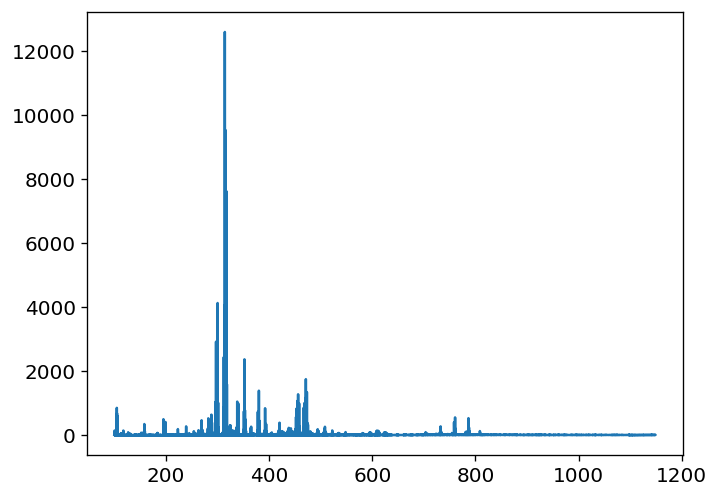

In [6]:
plt.plot(s_mzs, a_int)

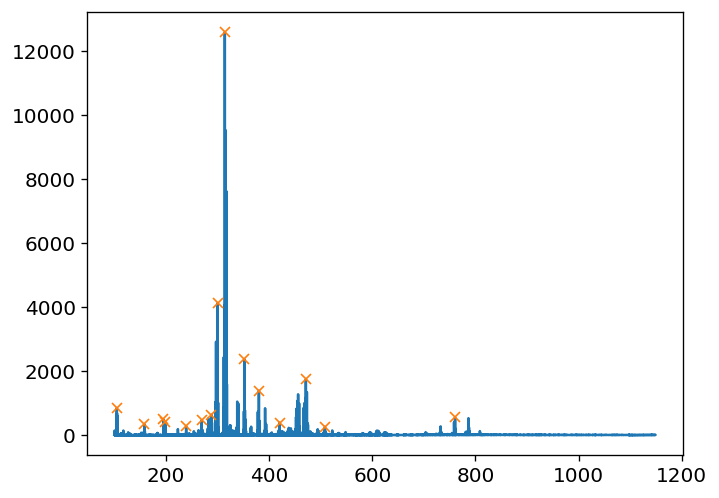

In [7]:
peaks, _ = scipy.signal.find_peaks(a_int, distance=a_int.size / 100)

peaks_good = np.argsort(-a_int[peaks])[:15]
peaks = peaks[peaks_good]

plt.plot(s_mzs, a_int)
plt.plot(s_mzs[peaks], a_int[peaks], "x")

In [10]:
def save_zcyx_as_ome_tiff(dest: str, cube: np.ndarray):

    suffix = ".ome.tiff"
    if dest[-len(suffix):] != suffix:
        raise ValueError("invalid path")

    assert cube.ndim == 4
    assert cube.shape[1] == 3
    
    with tifffile.TiffWriter(dest) as tiff_writer:
        tiff_writer.write(cube, photometric="RBG", metadata={"axes": "ZCYX"}, compression=None)

In [18]:
def iter_colorized_planes(img: np.ndarray, background_mask: np.ndarray):
    img_max_val = img.max()
    foreground_mask = ~background_mask
    
    for p in img:
        # colorize
        p_rgba = np.zeros(shape=p.shape+(4,), dtype=np.uint8)
        color_map = plt.cm.ScalarMappable(cmap=mpl.colormaps["gray"])

        # apply on the foreground only
        p_rgba[foreground_mask] = color_map.to_rgba(np.sqrt(p[foreground_mask]), bytes=True)

        # remove alpha channel for TIFF file
        p_rgb = PIL.Image.fromarray(p_rgba, mode='RGBA').convert('RGB')
        p_rgb = np.array(p_rgb)
        
        yield p_rgb

In [12]:
def save_as_tiff(dest: str, img: np.ndarray, background: np.ndarray):

    planes = list(iter_colorized_planes(img, background))
    
    plane_np = np.stack(planes)  # Z Y X C
    plane_np = np.transpose(plane_np, (0, 3, 1, 2))  # Z C Y X

    save_zcyx_as_ome_tiff(dest, plane_np)

In [13]:
n_len = r13["/labels/lengths/0"][0, 0]
roi_y, roi_x = autocrop(n_len)
r13_bg = n_len[roi_y, roi_x] == 0

img_stack = np.stack([r13["/0"][p, 0, roi_y, roi_x] for p in peaks], axis=0)

In [ ]:
# save_as_tiff("r13_peak_ion_image.ome.tiff", img_stack, background=r13_bg)

In [25]:
planes = list(iter_colorized_planes(img_stack, r13_bg))
sample_plane = planes[2]

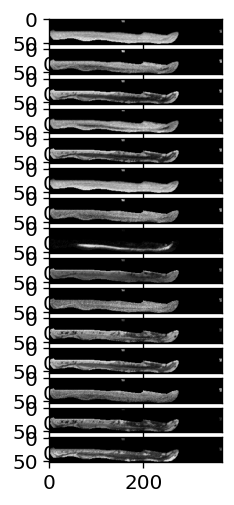

In [24]:
fig, axes = plt.subplots(nrows=len(planes), ncols=1, squeeze=False)
for i, p in enumerate(planes):
    axes[i, 0].imshow(p)

In [28]:
sample_img = np.asarray(PIL.Image.fromarray(sample_plane).convert("L"))

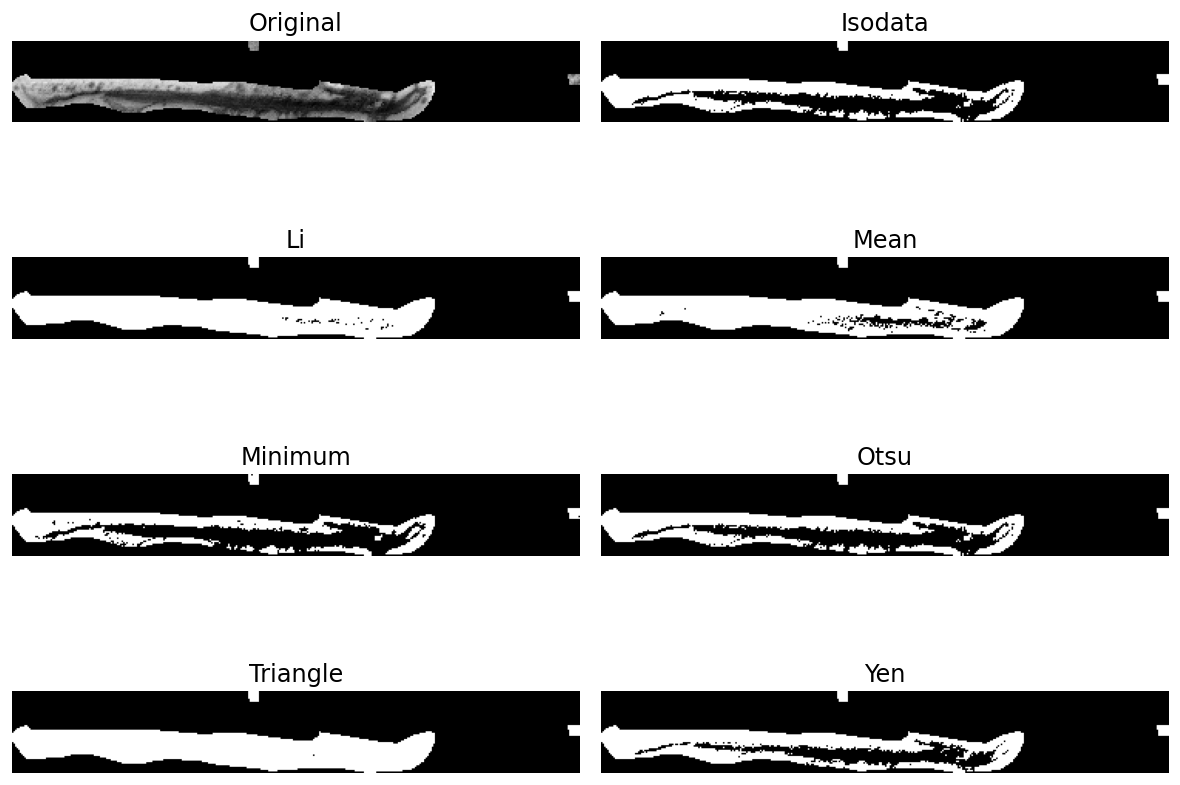

In [30]:
from skimage.filters import try_all_threshold, threshold_otsu

fig, ax = try_all_threshold(sample_img, figsize=(10, 8), verbose=False)

In [37]:
def filter_otsu(img):
    threshold = threshold_otsu(img)
    filtered = np.zeros_like(img)
    filtered[img > threshold] = 255
    return filtered

In [31]:
as_images = [np.asarray(PIL.Image.fromarray(p).convert("L")) for p in planes]

In [38]:
features = [filter_otsu(img) for img in as_images]

dtype('uint8')